# 1. Introduction

# Training a Custom Model on Stanford Images with TinyVGG Architecture

Welcome to this Jupyter notebook! In this project, I embark on a journey to train a custom image classification model using the Stanford Images dataset. Our architecture of choice is based on TinyVGG, a compact yet powerful convolutional neural network (CNN) inspired by the renowned VGG architecture.

## Introduction

Image classification is a fundamental task in computer vision, with applications ranging from medical diagnosis to autonomous driving. The Stanford Images dataset provides a rich collection of diverse images across various categories, making it an ideal choice for training and testing our model.

### The TinyVGG Architecture

TinyVGG is a simplified version of the VGG network, designed to strike a balance between model size and performance. It consists of multiple convolutional layers followed by max-pooling layers, culminating in fully connected layers for classification. Despite its compact size, TinyVGG has demonstrated impressive accuracy on a wide range of image classification tasks.

### Custom Dataset Preparation

Before diving into model training, we'll need to prepare our custom dataset using the Stanford Images. This involves data preprocessing, augmentation, and organization into the appropriate directory structure for compatibility with our model training pipeline.

## Objectives

- Preprocess and augment the Stanford Images dataset.
- Implement the TinyVGG architecture using PyTorch.
- Train the model on the custom dataset and evaluate its performance.

By the end of this notebook, you'll have gained hands-on experience in building and training convolutional neural networks for image classification tasks using PyTorch.

**References:**
1. [Stanford Cars Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset)
2. [CNN Explainer](https://poloclub.github.io/cnn-explainer/)
3. [Building Custom Datasets for PyTorch Deep Learning Image Classification](https://medium.com/@joshuale/building-custom-datasets-for-pytorch-deep-learning-image-classification-29989971652d)
4. [Building Custom Image Datasets in PyTorch](https://glassboxmedicine.com/2022/01/21/building-custom-image-data-sets-in-pytorch-tutorial-with-code/)
5. [Machine Learning tips and tricks cheatsheet](https://web.stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks)
6. [Deep Learning cheatsheet](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning)
7. [Learn PyTorch for Deep Learning](https://www.learnpytorch.io/)
8. [Switching among OpenCV, Tensorflow and Pillow?](https://towardsdatascience.com/image-read-and-resize-with-opencv-tensorflow-and-pil-3e0f29b992be)
9. [Custom Image Classifier with PyTorch - A Step-by-Step Guide](https://dilithjay.com/blog/custom-image-classifier-with-pytorch)
10. [Beginner’s Guide to Loading Image Data with PyTorch](https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec)

Let's dive in!


# 2. Imports and Setup

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Torch
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Dict, List
from torchinfo import summary

# Data manipulation
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path

# File I/O and system interaction
import os
import random
import shutil

# Visualization
import matplotlib.pyplot as plt

# Math and Science libraries
from scipy.io import loadmat

# Performance measurement
from timeit import default_timer as timer
import logging

# Print PyTorch Version
print(torch.__version__)


2.3.0+cpu


In [2]:
# Check for available device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Print the assigned device
print(f"Using device: {device}")

Using device: cpu


# 3. Data Loading and Preprocessing

In [3]:
# Setup path to data folder
data_path = Path("data/")

# Define root directory for the Stanford Car Dataset (replace if needed)
root_dir = Path(data_path / 'stanford_cars')

# Define directory for training data
train_dir = root_dir / "train"

# Define directory for test data
test_dir = root_dir / "test"

In [4]:
# Meta data for car image
cars_meta = loadmat(root_dir  / "cars_meta.mat")

# training imgaes
cars_train = loadmat(root_dir / "cars_train_annos.mat")

# test images 
cars_test_labels = loadmat(root_dir / "cars_test_annos_withlabels.mat")


## 3.1 Extract Car's meta information from the matlab files

In [5]:
# Getting theclass names 
cars_classes = cars_meta['class_names'][0]

data = []

# Initialize an empty DataFrame
df_classes = pd.DataFrame(columns=["class_name"])


for car in cars_classes:
    class_id = car[0]
    # Create a dictionary representing the data for this car
    car_data = {
        "class_name": class_id
    }
    
    # Append the dictionary to the list
    data.append(car_data)

# Convert the list of dictionaries to a DataFrame
df_classes = pd.DataFrame(data)

df_classes['class_index'] = df_classes.index + 1

df_classes.head()

,class_name,class_index
0,AM General Hummer SUV 2000,1
1,Acura RL Sedan 2012,2
2,Acura TL Sedan 2012,3
3,Acura TL Type-S 2008,4
4,Acura TSX Sedan 2012,5


## 3.2 Get the training images data 

In [6]:
# Get the training images data 
cars_train_annotations = cars_train['annotations'][0]


data = []
# Initialize an empty DataFrame
df_train = pd.DataFrame(columns=["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id"])


for car in cars_train_annotations:
    filename = car[5][0] # extract the filename from path and remove the left most 0 in filename : car_ims/016185.jpg 
    bbox_x1  = car[0][0][0]
    bbox_y1  = car[1][0][0]
    bbox_x2  = car[2][0][0]
    bbox_y2  = car[3][0][0]
    class_id = car[4][0][0]

    # Create a dictionary representing the data for this car
    car_data = {
        "file_name": filename,
        "bbox_x1": bbox_x1,
        "bbox_y1": bbox_y1,
        "bbox_x2": bbox_x2,
        "bbox_y2": bbox_y2,
        "class_index": class_id,
    }
    
    # Append the dictionary to the list
    data.append(car_data)

# Convert the list of dictionaries to a DataFrame
df_train = pd.DataFrame(data)

df_train.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [7]:
# Get th Class labels on training images data 
df_train = pd.merge(df_train, df_classes, on='class_index', how='inner')
df_train.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index,class_name
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


In [8]:
directory = '.\data\stanford_cars\train'
df_train['file_path'] = [os.path.join( 'data', 'stanford_cars', 'train', class_name, file_name)  
                        for class_name, file_name in zip(df_train['class_name'], df_train['file_name'])]
df_train.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index,class_name,file_path
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,data\stanford_cars\train\Audi TTS Coupe 2012\0...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,data\stanford_cars\train\Acura TL Sedan 2012\0...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,data\stanford_cars\train\Dodge Dakota Club Cab...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,data\stanford_cars\train\Hyundai Sonata Hybrid...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,data\stanford_cars\train\Ford F-450 Super Duty...


## 3.3 Get the testing image data

In [9]:
# Get the test images data 
cars_test_with_labels = cars_test_labels['annotations'][0]

data = []
# Initialize an empty DataFrame
df_test = pd.DataFrame(columns=["filename", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id"])


for car in cars_test_with_labels:

    filename = car[5][0]
    bbox_x1  = car[0][0][0]
    bbox_y1  = car[1][0][0]
    bbox_x2  = car[2][0][0]
    bbox_y2  = car[3][0][0]
    class_id = car[4][0][0]
    # Create a dictionary representing the data for this car
    car_data = {
        "file_name": filename,
        "bbox_x1": bbox_x1,
        "bbox_y1": bbox_y1,
        "bbox_x2": bbox_x2,
        "bbox_y2": bbox_y2,
        "class_index": class_id
    }
    
    # Append the dictionary to the list
    data.append(car_data)

# Convert the list of dictionaries to a DataFrame
df_test = pd.DataFrame(data)


df_test.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [10]:
df_test = pd.merge(df_test, df_classes, on='class_index', how='inner')

df_test.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index,class_name
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012


In [11]:
directory = '.\data\stanford_cars\test'
df_test['file_path'] = [os.path.join( 'data', 'stanford_cars', 'test', class_name, file_name) 
                        for class_name, file_name in zip(df_test['class_name'], df_test['file_name'])]
df_test.head()

,file_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_index,class_name,file_path
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,data\stanford_cars\test\Suzuki Aerio Sedan 200...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,data\stanford_cars\test\Ferrari 458 Italia Con...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,data\stanford_cars\test\Jeep Patriot SUV 2012\...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,data\stanford_cars\test\Toyota Camry Sedan 201...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,data\stanford_cars\test\Tesla Model S Sedan 20...


In [12]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")

## 3.4 Class distribution in training dataset

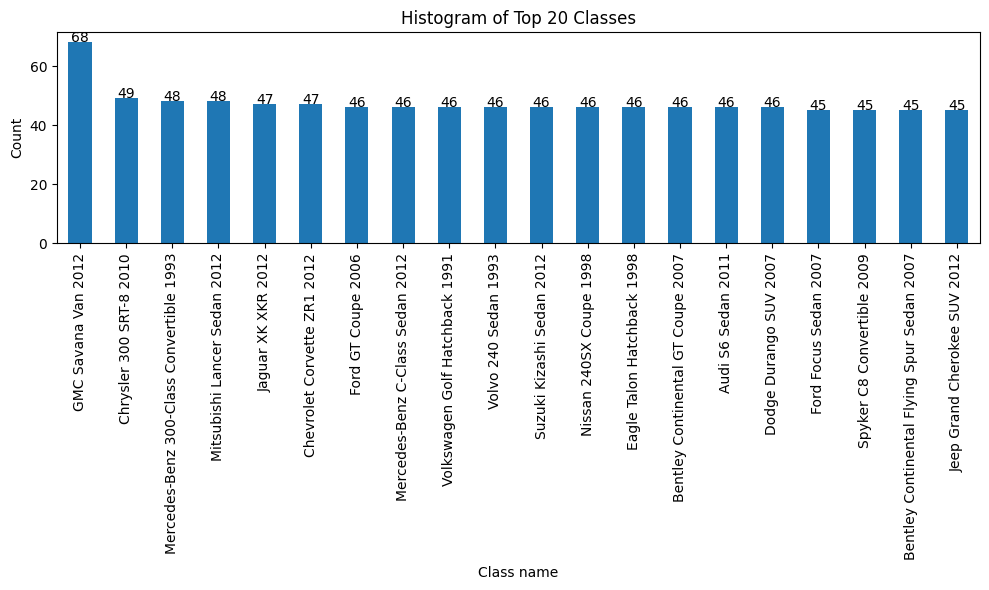

In [13]:
# Count the occurrences of each label
class_counts = df_train['class_name'].value_counts()

# Select the top 20 labels
top_20_labels = class_counts.head(20)

# Plot the histogram for top 20 labels with counts on the y-axis
plt.figure(figsize=(10, 6))
top_20_labels.plot(kind='bar')
plt.title('Histogram of Top 20 Classes')
plt.xlabel('Class name')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Add counts on top of each bar
for i, count in enumerate(top_20_labels):
    plt.text(i, count + 0.2, str(count), ha='center')

plt.tight_layout()
plt.show()

## 3.5 Organising Stanford Car Dataset Images

## Dataset Organisation Options

Organising images into folders by class and consolidating all training images into a single folder for all classes represent distinct approaches. Both approaches have their advantages and disadvantages, and the choice often depends on the specific requirements of the project. Here's a breakdown of both options:

1. **Separate Folder per Class**:
   - **Advantages**:
     - Organizational clarity: Keeping images in separate folders makes it easy to understand the structure of the dataset.
     - Ease of access: When you're working with specific classes, having them in separate folders simplifies loading and accessing data during training.
     - Compatibility: Many machine learning frameworks and libraries have built-in utilities to work with datasets organized in this way, making implementation easier.
   - **Disadvantages**:
     - Potential scalability issues: If you have a large number of classes, managing and navigating through many folders might become cumbersome.
     - Duplication: If an image belongs to multiple classes, you may need to duplicate it across folders, which can waste storage space.

2. **All Images in a Single Folder (No Class Separation)**:
   - **Advantages**:
     - Simplicity: This approach simplifies the dataset structure, making it easier to manage, especially when dealing with a large number of classes.
     - Flexibility: You can easily add new classes without creating additional folders.
     - No duplication: Each image exists only once, reducing the risk of redundancy and saving storage space.
   - **Disadvantages**:
     - Potential confusion: It may be more challenging to understand the dataset structure at a glance, especially for someone new to the project.
     - Extra preprocessing: You'll need to include labels or metadata indicating the class for each image, adding an additional preprocessing step.
     - Access efficiency: Accessing specific classes during training may require additional filtering or sorting steps, potentially impacting performance.

If the dataset is relatively small and manageable, organising images into separate folders per class might offer better clarity and ease of use. However, if scalability and simplicity are more critical, keeping all images in a single folder with class labels might be a better option.




### 3.5.1 Moving images from "All Images in a Single Folder" to Seprate Folder per Class

In [14]:
def move_images(df, source_folder, target_folder):
    """
    Move images from the source folder to the target folder based on the labels provided in the DataFrame.

    Args:
    - df: DataFrame containing file names and corresponding labels.
    - source_folder: Path to the folder where images are currently located.
    - target_folder: Path to the folder where images will be moved.

    Returns:
    - None
    """
    for _, row in df.iterrows():
        # Construct the source file path
        image_path = os.path.join(source_folder, row['fname'])
        # Get the label of the image
        label = row['labels']
        
        # Construct the destination folder path based on the label
        destination_folder = os.path.join(target_folder, label)

        # Create the destination folder if it doesn't exist
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        
        # Move the image to the destination folder
        destination_file = os.path.join(target_folder, label, row['fname'])
        if not os.path.exists(destination_file):
            shutil.move(image_path, destination_file)

def move_main(train):
    """
    Move images from the old Stanford Cars dataset to the corresponding folders in the new dataset.

    Args:
    - train: An integer indicating whether to move images from the training set (train=1) or the test set (train=0).

    Returns:
    - None
    """
    if train == 0:
        df = df_test
        target_folder = test_dir
        source_folder = "data/old_stanford_cars/cars_test/"

    if train == 1:
        df = df_train
        target_folder = train_dir
        source_folder = "data/old_stanford_cars/cars_train/"
    
    # Move images to corresponding folders
    move_images(df, source_folder, target_folder)

# Only run it once
RUN = 0
if RUN == 1:
    move_main(train=0)
    move_main(train=1)

In [15]:
def walk_through_dir(dir_path: str | Path) -> None:
  """
  Analyzes a directory and prints information about its subdirectories and images.

  Args:
      dir_path (str or pathlib.Path): The path to the directory to be analyzed.

  Returns:
      None: This function doesn't return any value, it directly prints the results.
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    # Count subdirectories and images
    num_subdirs = len(dirnames)
    num_images = len(filenames)

    # Print information for each directory
    print(f"There are {num_subdirs} directories and {num_images} images in '{dirpath}'.")

# Call the function with the root directory
walk_through_dir(root_dir)


There are 2 directories and 5 images in 'data\stanford_cars'.
There are 196 directories and 0 images in 'data\stanford_cars\test'.
There are 0 directories and 44 images in 'data\stanford_cars\test\Acura Integra Type R 2001'.
There are 0 directories and 32 images in 'data\stanford_cars\test\Acura RL Sedan 2012'.
There are 0 directories and 43 images in 'data\stanford_cars\test\Acura TL Sedan 2012'.
There are 0 directories and 42 images in 'data\stanford_cars\test\Acura TL Type-S 2008'.
There are 0 directories and 40 images in 'data\stanford_cars\test\Acura TSX Sedan 2012'.
There are 0 directories and 39 images in 'data\stanford_cars\test\Acura ZDX Hatchback 2012'.
There are 0 directories and 44 images in 'data\stanford_cars\test\AM General Hummer SUV 2000'.
There are 0 directories and 45 images in 'data\stanford_cars\test\Aston Martin V8 Vantage Convertible 2012'.
There are 0 directories and 41 images in 'data\stanford_cars\test\Aston Martin V8 Vantage Coupe 2012'.
There are 0 directori

## 3.6 Exploring a Random Image from the Stanford Car Dataset

Random image path: data\stanford_cars\train\Chevrolet Express Cargo Van 2007\03651.jpg
Image class: Chevrolet Express Cargo Van 2007
Image height: 480
Image width: 640


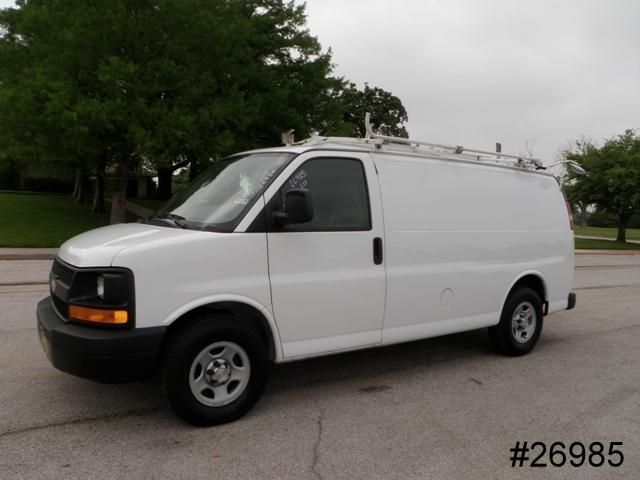

In [16]:
# Set random seed (optional)
random.seed(42)

# 1. Get all image paths recursively (using globbing)
image_path_list = list(root_dir.glob("**/*.jpg"))  # Include subdirectories

# 2. Get a random image path
random_image_path = random.choice(image_path_list)

# 3. Extract image class from path (class is the directory name)
image_class = random_image_path.parent.stem

# 4. Open the image using Pillow
img = Image.open(random_image_path)

# 5. Print image metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# 6. Display the image (optional)
img


## 3.7 Convert image to NumPy array and plot

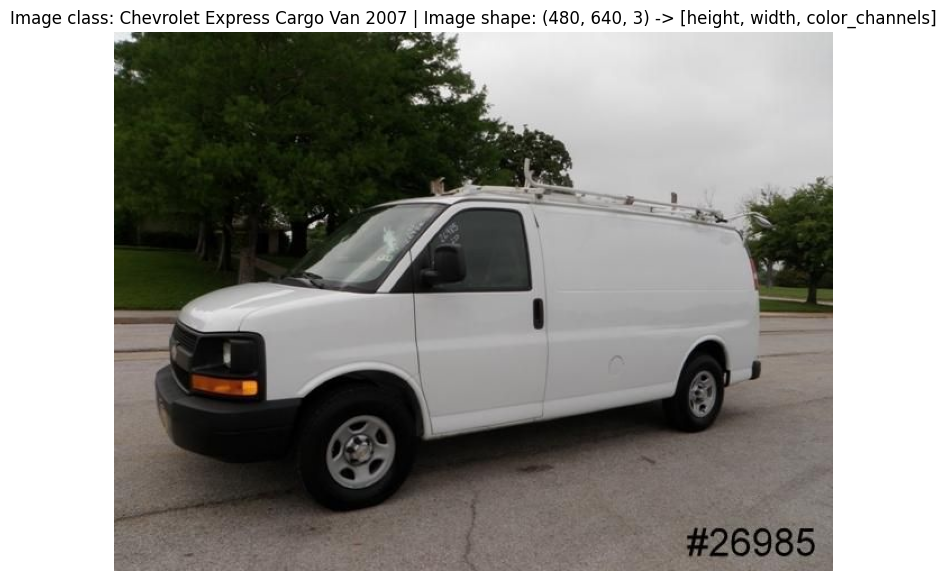

In [17]:
# Convert image to NumPy array
img_as_array = np.asarray(img)

# Plot the image using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)

# Set informative title
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")

# Hide axes for cleaner visualization
plt.axis('off')

# Display the plot
plt.show()


# 4. Model

## 4.1 Custom Image Dataset for PyTorch (StanfordCarsCustom)

In [19]:
# Configure logging
logging.basicConfig(level=logging.INFO)  # Set logging level as needed

# 1. Subclass torch.utils.data.Dataset
class StanfordCarsCustom(Dataset):
  """Custom Image Dataset for PyTorch.

  This class loads images from a directory structure where subdirectories
  represent image classes. It inherits from `torch.utils.data.Dataset` 
  to provide a structured way to access and manage image data.

  Args:
      targ_dir (str): Path to the target directory containing images.
      transform (torchvision.transforms, optional): Transformations to apply to images.
  """

  # 2. Initialize with directory and transform (optional)
  def __init__(self, annotations_file, transform=None) -> None:
    """
    Initializes the StanfordCarsCustom dataset.

    Args:
        annotations_file (str): Path to the target directory containing images.
        transform (torchvision.transforms, optional): Transformations to apply to images.
    """

    # 3. Create class attribute
    self.annotation_df = pd.read_csv(annotations_file)
    self.transform = transform
    self.classes = self.annotation_df['class_name'].unique()
    # Logging initialization
    self.logger = logging.getLogger(__name__)
    

  # 5. Overwrite __len__() method (optional but recommended)
  def __len__(self) -> int:
    """
    Returns the total number of images in the dataset.

    Returns:
        int: The total number of images.
    """

    return len(self.annotation_df)

  # 6. Overwrite __getitem__() method (required)
  def __getitem__(self, idx: int):
    """
    Retrieves one sample (image and its class label) from the dataset.

    Args:
        idx (int): Index of the sample to retrieve.

    Returns:
        Tuple[torch.Tensor, dict]: A tuple containing the image as a PyTorch tensor
                                    and its corresponding class information as a dictionary.
    """
    try:
        img_path = self.annotation_df.iloc[idx, 8] #use image path column (index = 1) in csv file
        
    

        # Error handling for corrupted files
        if img_path is None:
            raise Exception(f"Failed to read image: {img_path}")

        image = Image.open(img_path)

        # self.logger.info(f"Loading image from path: {img_path}, image shape is {channels} x {image_width} x {image_height}")
        class_name = self.annotation_df.iloc[idx, 7] # use class name column (index = 6) in csv file
        class_index = self.annotation_df.iloc[idx, 6] - 1 # use class index column (index = 5) in csv file

        class_dict = {
            'class_name': class_name,
            'class_index': class_index
        }
    
        if self.transform:
            image = self.transform(image)
        return image, class_dict
  
    except Exception as e:
        self.logger.error(f"Error loading image: {img_path} - {e}")
        # Handle error (raise, skip image, etc.)
        # Here, we'll skip the image for simplicity
        return None, None

Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>
Type of image from Custom Dataset : <class 'PIL.JpegImagePlugin.JpegImageFile'>


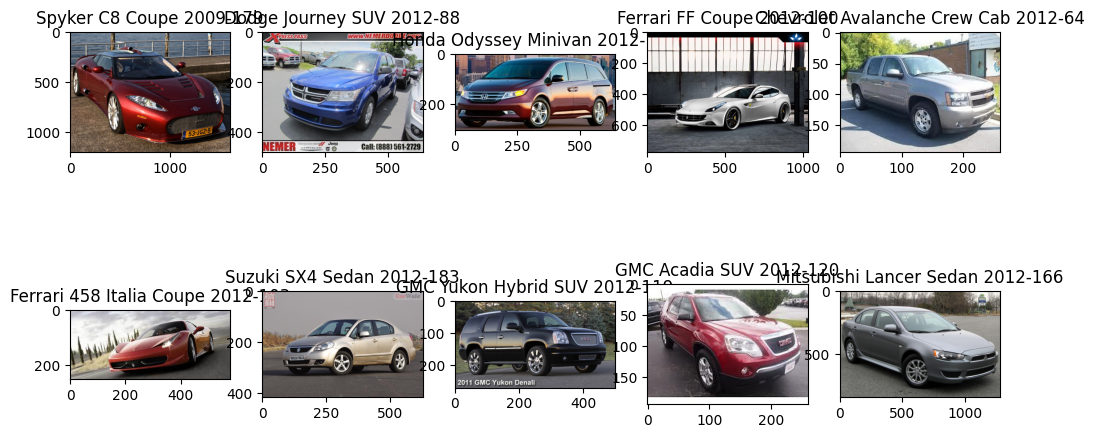

In [20]:
#test dataset class without transformation:
train_dataset_untransformed = StanfordCarsCustom(annotations_file='train.csv', transform=None)

train_dataloader_untransformed = DataLoader(train_dataset_untransformed, batch_size=64, shuffle=True)

#visualize 10 random images from the loaded dataset
plt.figure(figsize=(12,6))
for i in range(10):
    idx = random.randint(0, len(train_dataloader_untransformed))
    img, class_dict = train_dataset_untransformed[idx]
    print(f'Type of image from Custom Dataset : {type(img)}')
    # print(f'Type of image from Custom Dataset : {img.shape}')

    class_name = class_dict['class_name']  # Extract the class name from the dictionary
    class_index = class_dict['class_index'] 
    ax=plt.subplot(2,5,i+1) # create an axis
    ax.title.set_text("-".join([class_name, str(class_index)]))  # create a name of the axis based on the img name
    plt.imshow( np.asarray(img)) # show the img

## 4.2 Transform with data augmentation

In [21]:
# Define image transformation using torchvision.transforms
train_transform = transforms.Compose([

    transforms.Resize((64, 64)),

    # Check if the image is grayscale, if not, convert to grayscale while keeping 3 channels
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 

    # Randomly flip images horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),

    # Convert PIL images to PyTorch tensors
    transforms.ToTensor()  # Also normalizes pixel values to [0.0, 1.0]
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([

    transforms.Resize((64, 64)),
    # Check if the image is grayscale, if not, convert to grayscale while keeping 3 channels
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    transforms.ToTensor()
])

In [22]:
BATCH_SIZE = 10
NUM_WORKERS = 0#os.cpu_count()

train_dataset_transformed = StanfordCarsCustom(annotations_file='train.csv', transform=train_transform)

train_dataloader_transformed = DataLoader(train_dataset_transformed, batch_size=10, shuffle=True)

test_dataset_transformed = StanfordCarsCustom(annotations_file='test.csv', transform=test_transform)

test_dataloader_transformed = DataLoader(test_dataset_transformed, batch_size=10, shuffle=True)


## 4.3 Create custom dataset 

### 4.3.1 Show the transformed images

In [23]:
image_path_list = df_train['file_path'].tolist()
image_path_list

['data\\stanford_cars\\train\\Audi TTS Coupe 2012\\00001.jpg',
 'data\\stanford_cars\\train\\Acura TL Sedan 2012\\00002.jpg',
 'data\\stanford_cars\\train\\Dodge Dakota Club Cab 2007\\00003.jpg',
 'data\\stanford_cars\\train\\Hyundai Sonata Hybrid Sedan 2012\\00004.jpg',
 'data\\stanford_cars\\train\\Ford F-450 Super Duty Crew Cab 2012\\00005.jpg',
 'data\\stanford_cars\\train\\Geo Metro Convertible 1993\\00006.jpg',
 'data\\stanford_cars\\train\\Dodge Journey SUV 2012\\00007.jpg',
 'data\\stanford_cars\\train\\Dodge Charger Sedan 2012\\00008.jpg',
 'data\\stanford_cars\\train\\Mitsubishi Lancer Sedan 2012\\00009.jpg',
 'data\\stanford_cars\\train\\Chevrolet Traverse SUV 2012\\00010.jpg',
 'data\\stanford_cars\\train\\Buick Verano Sedan 2012\\00011.jpg',
 'data\\stanford_cars\\train\\Toyota Sequoia SUV 2012\\00012.jpg',
 'data\\stanford_cars\\train\\Hyundai Elantra Sedan 2007\\00013.jpg',
 'data\\stanford_cars\\train\\Dodge Caravan Minivan 1997\\00014.jpg',
 'data\\stanford_cars\\train

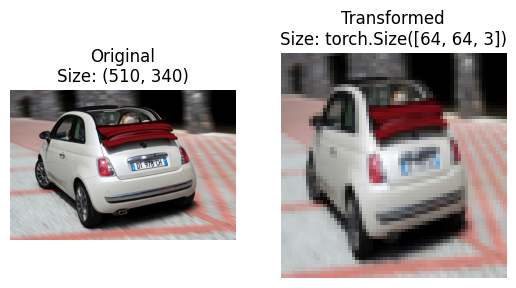

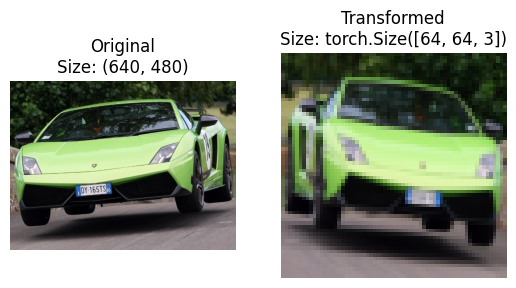

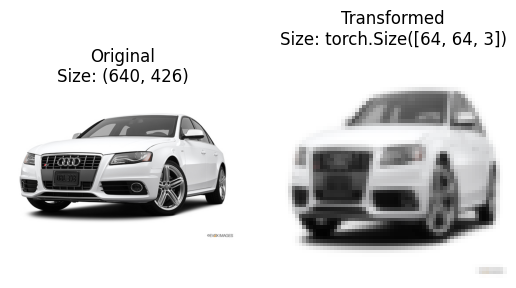

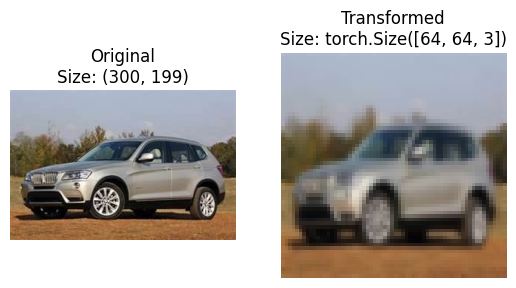

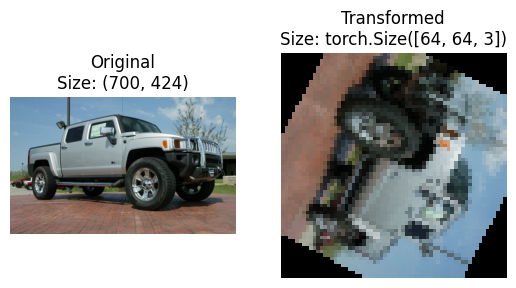

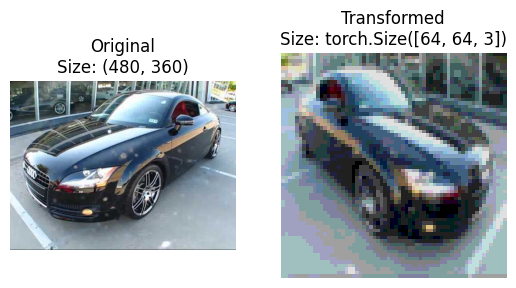

In [24]:
def plot_transformed_images(image_paths: list[str], transform: transforms.Compose, n: int = 3, seed: int = 42) -> None:
  """
  Visualizes a comparison of original and transformed images.

  This function randomly selects a specified number of images from the provided list,
  applies the given transformation to each image, and plots the original and transformed versions side-by-side.

  Args:
      image_paths (list[str]): A list containing paths to the target images.
      transform (transforms.Compose): A PyTorch transformation object defining the operations to be applied.
      n (int, optional): The number of images to select and plot. Defaults to 3.
      seed (int, optional): The random seed for consistent image selection (reproducibility). Defaults to 42.

  Returns:
      None: This function doesn't return any value, it directly creates and displays the plot.
  """

  # Set random seed for consistent image selection
  random.seed(seed)

  # Select a random sample of image paths
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    # Open the image
    with Image.open(image_path) as f:

      # Create figure and subplots
      fig, (ax1, ax2) = plt.subplots(1, 2)

      # Plot original image with title and disable axes
      ax1.imshow(f)
      ax1.set_title(f"Original\nSize: {f.size}")
      ax1.axis("off")

      # Apply transformation and convert for Matplotlib
      transformed_image = transform(f).permute(1, 2, 0)  # Adjust channel order for Matplotlib

      # Plot transformed image with title and disable axes
      ax2.imshow(transformed_image)
      ax2.set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax2.axis("off")

  # Display the plot
  plt.show()

# Example usage with 3 images
plot_transformed_images(image_path_list, transform=train_transform, n=6)


## 4.4 Model Definition

### 4.4.1 Create TinyVGG model class

In [25]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x


torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(set(train_dataset_transformed.classes))).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=196, bias=True)
  )
)

## 4.4.2 Use torchinfo to get an idea of the shapes going through our model

In [26]:
summary(model_0, input_size=[10, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [10, 196]                 --
├─Sequential: 1-1                        [10, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [10, 10, 64, 64]          280
│    └─ReLU: 2-2                         [10, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [10, 10, 64, 64]          910
│    └─ReLU: 2-4                         [10, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [10, 10, 32, 32]          --
├─Sequential: 1-2                        [10, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [10, 10, 32, 32]          910
│    └─ReLU: 2-7                         [10, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [10, 10, 32, 32]          910
│    └─ReLU: 2-9                         [10, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [10, 10, 16, 16]          --
├─Sequentia

## 4.5 Create train & test loop functions

In [27]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch_idx, (images, class_dict) in enumerate(dataloader):

        if images is None or class_dict is None: 
            continue
        # Send data to target device
        X = images.to(device)
        y = class_dict['class_index'].to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)

        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches

        for batch_idx, (images, class_dict) in enumerate(dataloader):
            # Send data to target device
            X = images.to(device)
            y = class_dict['class_index'].to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 4.6 Creating a train() function to combine train_step() and test_step()

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\dev\Python\stanford_cars\stanford_cars\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4.7 Train and Evaluate Model

In [29]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(set(train_dataset_transformed.classes))).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, #train_dataloader_transformed
                        train_dataloader=train_dataloader_transformed,
                        test_dataloader=test_dataloader_transformed,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [03:29<1:41:22, 209.75s/it]

Epoch: 1 | train_loss: 5.2821 | train_acc: 0.0054 | test_loss: 5.2763 | test_acc: 0.0084


  7%|▋         | 2/30 [06:47<1:34:30, 202.50s/it]

Epoch: 2 | train_loss: 5.2779 | train_acc: 0.0083 | test_loss: 5.2752 | test_acc: 0.0084


 10%|█         | 3/30 [11:23<1:46:21, 236.33s/it]

Epoch: 3 | train_loss: 5.2772 | train_acc: 0.0080 | test_loss: 5.2743 | test_acc: 0.0084


 13%|█▎        | 4/30 [14:36<1:34:53, 218.98s/it]

Epoch: 4 | train_loss: 5.2763 | train_acc: 0.0083 | test_loss: 5.2738 | test_acc: 0.0084


 17%|█▋        | 5/30 [17:51<1:27:39, 210.36s/it]

Epoch: 5 | train_loss: 5.2758 | train_acc: 0.0083 | test_loss: 5.2733 | test_acc: 0.0084


 20%|██        | 6/30 [21:05<1:21:55, 204.80s/it]

Epoch: 6 | train_loss: 5.2754 | train_acc: 0.0083 | test_loss: 5.2731 | test_acc: 0.0084


 23%|██▎       | 7/30 [25:18<1:24:33, 220.57s/it]

Epoch: 7 | train_loss: 5.2752 | train_acc: 0.0083 | test_loss: 5.2731 | test_acc: 0.0084


 27%|██▋       | 8/30 [30:55<1:34:31, 257.78s/it]

Epoch: 8 | train_loss: 5.2751 | train_acc: 0.0083 | test_loss: 5.2728 | test_acc: 0.0084


 30%|███       | 9/30 [33:54<1:21:36, 233.14s/it]

Epoch: 9 | train_loss: 5.2750 | train_acc: 0.0083 | test_loss: 5.2726 | test_acc: 0.0084


 33%|███▎      | 10/30 [37:11<1:13:59, 221.97s/it]

Epoch: 10 | train_loss: 5.2749 | train_acc: 0.0083 | test_loss: 5.2726 | test_acc: 0.0084


 37%|███▋      | 11/30 [40:42<1:09:14, 218.64s/it]

Epoch: 11 | train_loss: 5.2749 | train_acc: 0.0083 | test_loss: 5.2725 | test_acc: 0.0084


 40%|████      | 12/30 [44:01<1:03:45, 212.51s/it]

Epoch: 12 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2725 | test_acc: 0.0084


 43%|████▎     | 13/30 [47:00<57:20, 202.40s/it]  

Epoch: 13 | train_loss: 5.2749 | train_acc: 0.0083 | test_loss: 5.2725 | test_acc: 0.0084


 47%|████▋     | 14/30 [49:56<51:52, 194.51s/it]

Epoch: 14 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2726 | test_acc: 0.0084


 50%|█████     | 15/30 [52:50<47:03, 188.24s/it]

Epoch: 15 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2726 | test_acc: 0.0084


 53%|█████▎    | 16/30 [55:48<43:11, 185.13s/it]

Epoch: 16 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2727 | test_acc: 0.0084


 57%|█████▋    | 17/30 [58:53<40:06, 185.09s/it]

Epoch: 17 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 60%|██████    | 18/30 [1:01:49<36:30, 182.55s/it]

Epoch: 18 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2728 | test_acc: 0.0084


 63%|██████▎   | 19/30 [1:04:56<33:40, 183.68s/it]

Epoch: 19 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 67%|██████▋   | 20/30 [1:07:52<30:13, 181.38s/it]

Epoch: 20 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2725 | test_acc: 0.0084


 70%|███████   | 21/30 [1:11:50<29:46, 198.53s/it]

Epoch: 21 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 73%|███████▎  | 22/30 [1:15:00<26:07, 195.89s/it]

Epoch: 22 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2726 | test_acc: 0.0084


 77%|███████▋  | 23/30 [1:19:56<26:22, 226.04s/it]

Epoch: 23 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 80%|████████  | 24/30 [1:24:51<24:39, 246.62s/it]

Epoch: 24 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 83%|████████▎ | 25/30 [1:28:27<19:47, 237.47s/it]

Epoch: 25 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2723 | test_acc: 0.0084


 87%|████████▋ | 26/30 [1:31:29<14:43, 220.76s/it]

Epoch: 26 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 90%|█████████ | 27/30 [1:34:32<10:28, 209.51s/it]

Epoch: 27 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 93%|█████████▎| 28/30 [1:37:24<06:36, 198.25s/it]

Epoch: 28 | train_loss: 5.2747 | train_acc: 0.0083 | test_loss: 5.2724 | test_acc: 0.0084


 97%|█████████▋| 29/30 [1:40:10<03:08, 188.42s/it]

Epoch: 29 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2725 | test_acc: 0.0084


100%|██████████| 30/30 [1:43:11<00:00, 206.40s/it]

Epoch: 30 | train_loss: 5.2748 | train_acc: 0.0083 | test_loss: 5.2723 | test_acc: 0.0084
Total training time: 6191.935 seconds


In [30]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

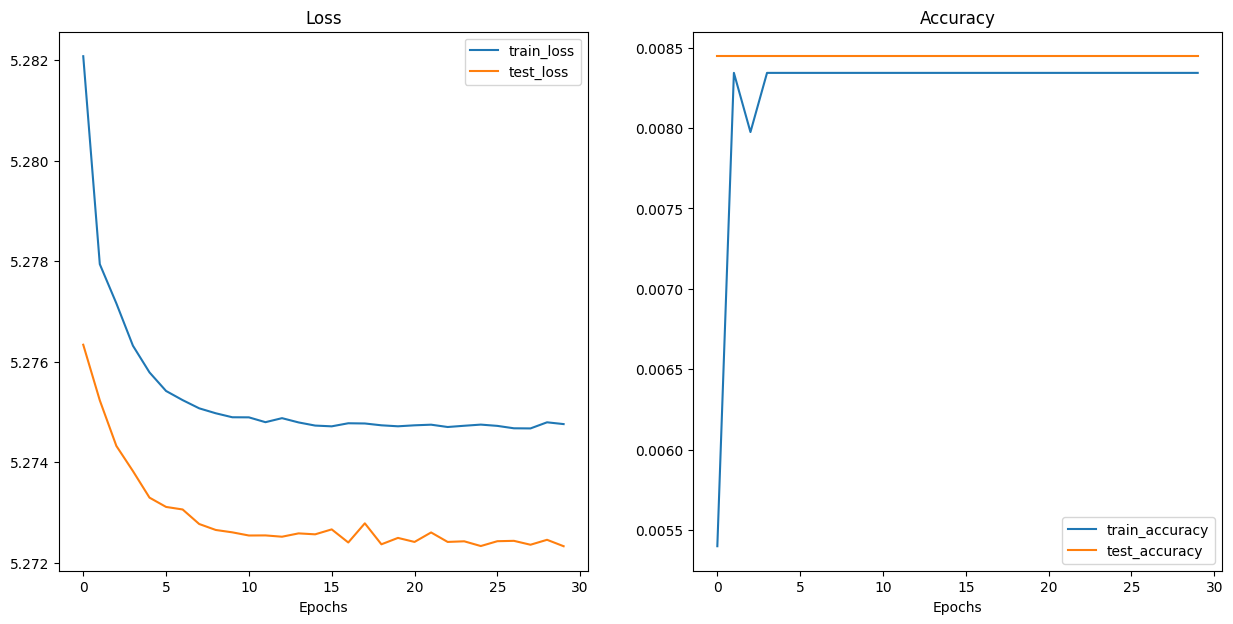

In [31]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
            #  "test_loss": [...],
            #  "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(model_0_results)